Github Source (Bias) - https://github.com/conversationai/unintended-ml-bias-analysis

#Introduction

Bias is common among authors in order to get readers to share an opinion, confirming what they already believe or sway readers to changing their opinions. Here we tried to see if we could spot this bias given any text.

The two techniques that we will attempt to implement are:
*   Given a topic of a document, can you find antonyms of words in the topic
*   Given a topic of a document, use cosine similarity between the words in the topic. If it passes a certain threshold, then we can label them bias/unbias

We will go in detail on why we attempted two different techniques.

In [0]:
import pandas as pd
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
import gensim
import nltk.sentiment
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer
import nltk 
from nltk.corpus import wordnet
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [0]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Data Loading

In [0]:
# ITERATION 3

# Load Dataset from drive
news = pd.read_csv('/content/drive/My Drive/MLSpring2020/TheMeanSquares-StockPrediction/Alternus-Vera TheMeanSquares/Iteration 1/Datasets/articles3.csv', low_memory =False)
n = 20
# news = news.head(int(len(news)*(n/100)))
news = news.head(500)
news.head()


,Unnamed: 0,id,title,publication,author,date,year,month,url,content
0,103459,151908,Alton Sterling’s son: ’Everyone needs to prote...,Guardian,Jessica Glenza,2016-07-13,2016.0,7.0,https://www.theguardian.com/us-news/2016/jul/1...,The son of a Louisiana man whose father was sh...
1,103460,151909,Shakespeare’s first four folios sell at auctio...,Guardian,NaN,2016-05-25,2016.0,5.0,https://www.theguardian.com/culture/2016/may/2...,Copies of William Shakespeare’s first four boo...
2,103461,151910,My grandmother’s death saved me from a life of...,Guardian,Robert Pendry,2016-10-31,2016.0,10.0,https://www.theguardian.com/commentisfree/2016...,"Debt: $20, 000, Source: College, credit cards,..."
3,103462,151911,I feared my life lacked meaning. Cancer pushed...,Guardian,Bradford Frost,2016-11-26,2016.0,11.0,https://www.theguardian.com/commentisfree/2016...,"It was late. I was drunk, nearing my 35th birt..."
4,103463,151912,Texas man serving life sentence innocent of do...,Guardian,NaN,2016-08-20,2016.0,8.0,https://www.theguardian.com/us-news/2016/aug/2...,A central Texas man serving a life sentence fo...


This data that we are loading was for iteration 3 (Implementing using the antonyms technique). This was just a random news dataset which I thought would be a good dataset to test if it could find any antonyms of words in a topic and see if they exist in the words of topic to describe variation.

# Preprocessing

In [0]:
# ITERATION 3
news = news.dropna()

In [0]:
# ITERATION 3
import re

def cleaning(raw_news):
    
    # 1. Remove non-letters/Special Characters and Punctuations
    # news = re.sub("[^a-zA-Z]", "", raw_news)
    news = re.sub("[,\.!?]", "", raw_news)
    # 2. Convert to lower case.
    news =  news.lower()
    
    # 3. Tokenize.
    news_words = nltk.word_tokenize( news)
    
    # 4. Convert the stopwords list to "set" data type.
    stops = set(nltk.corpus.stopwords.words("english"))
    
    # 5. Remove stop words. 
    words = [w for w in  news_words  if not w in stops]
    
    # 6. Lemmentize 
    wordnet_lem = [ WordNetLemmatizer().lemmatize(w) for w in words ]
    
    # 7. Stemming
    stems = [nltk.stem.SnowballStemmer('english').stem(w) for w in wordnet_lem ]
    
    # 8. Join the stemmed words back into one string separated by space, and return the result.
    return " ".join(stems)

In [0]:
# ITERATION 3
import time

t1 = time.time()
news['clean_content'] = news["content"].apply(cleaning) 
t2 = time.time()
print("\nTime to clean, tokenize and stem title in news: \n", len(news), "news:", (t2-t1)/60, "min")


Time to clean, tokenize and stem title in news: 
 396 news: 0.12834793329238892 min


These were data cleaning techniques such as lowering, tokenizing, convering stopwords, lemmetizing, and stemming. These steps I took from the professor so help with our implementation techniques.

# Biased

In [0]:
# ITERATION 3
news.shape

(396, 11)

This again is the first technique/implementation to figure out if a number of antonyms on the topic can be used to help determine variation. 

In [0]:
# Iteration 3

# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer
import nltk 
from nltk.corpus import wordnet


# Helper function
def print_topics(model, count_vectorizer, n_top_words):
   
    words = count_vectorizer.get_feature_names()
    num_ant = 0
    for topic_idx, topic in enumerate(model.components_):

        top_words = [words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        for word in top_words:
          ant = list()
          for synset in wordnet.synsets(word):
            for lemma in synset.lemmas():
                if lemma.antonyms():    #When antonyms are available, add them into the list
                  ant.append(lemma.antonyms()[0].name())
          
          found_ant = False
          for a in ant:
            if a in top_words:
              found_ant = True
              
          if found_ant:
            num_ant = num_ant + 1
    return num_ant

# Tweak the two parameters below
number_topics = 1
number_words = 10
results = []
for index, row in news.iterrows():
  
  count_vectorizer = CountVectorizer(stop_words='english')
  count_data = count_vectorizer.fit_transform([row['clean_content']])

  # Create and fit the LDA model
  lda = LDA(n_components=number_topics, n_jobs=-1)
  lda.fit(count_data)
  # Print the topics found by the LDA model
  # print("Topics found via LDA:")
  results.append(print_topics(lda, count_vectorizer, number_words))
print(results)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(0, 0.5, 'Docs')

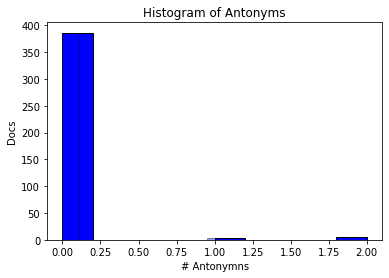

In [0]:
# Import the libraries
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib histogram
plt.hist(results, color = 'blue', edgecolor = 'black')

# seaborn histogram
sns.distplot(results, hist=True, kde=False, color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of Antonyms')
plt.xlabel('# Antonymns')
plt.ylabel('Docs')

Here we wanted to see the distribution of the number of antonyms found and how many docs had the same number of antonymns. We can see that this technique will not work, especially when for the majority it is finding zero antonyms. We went back to the drawing board and were suggested by the professor to try using cosine similarity instead and seeing if there was a distinction between the two unbias and biased articles.

In [0]:
model = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/My Drive/MLSpring2020/TheMeanSquares-StockPrediction/Alternus-Vera TheMeanSquares/Iteration 1/Datasets/GoogleNews-vectors-negative300.bin.gz', binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:

"""
Get 10 articles that are biased
Get 10 articles that are unbiased
	Per document from each set:
		Do LDA on that:
			Word2Vec for each word you get from LDA:
				Find Cosine similarity between those words
					if words close together
						biased
					else
						unbiased
					
					(You confirm this with the label of the document)
"""
import gensim 
from gensim.models import Word2Vec 

# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    results = []
    for topic_idx, topic in enumerate(model.components_):
        # print("\nTopic #%d:" % topic_idx)
        results = [words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    print(results)
    return results

def lda_cs_result(file_name):
  number_topics = 1
  number_words = 10
  
  # Loading data
  news = pd.read_csv('/content/drive/My Drive/MLSpring2020/TheMeanSquares-StockPrediction/Alternus-Vera TheMeanSquares/Iteration 1/Datasets/' + file_name, low_memory =False)
  # Data cleaning
  news['clean_content'] = news["content"].apply(cleaning) 
  news = news[:10]

  # Keeping track of avg cosine similarity score 
  all_count = 0
  all_value = 0
  results_final = []
  for index, row in news.iterrows():
    if row['clean_content'].strip() != '':
      print("-----------------------------------------------")
      # Setting up count vectorizer
      count_vectorizer = CountVectorizer(stop_words='english')
      count_data = count_vectorizer.fit_transform([row['clean_content']])
      
      # Create and fit the LDA model
      lda = LDA(n_components=number_topics, n_jobs=-1)
      lda.fit(count_data)

      # Print the topics found by the LDA model
      temp_results = print_topics(lda, count_vectorizer, number_words)

      results = []
      # Removing words that don't exist
      for tr in temp_results:
        if tr in model.wv.vocab:
          results.append(tr)
      
      # Looping through each word, finding cosine similarity against others
      for i in range(len(results)):
        for j in range(len(results)):
          if i != j:
            all_value = all_value + model.wv.similarity(results[i], results[j])
            all_count = all_count + 1
            results_final.append(model.wv.similarity(results[i], results[j]))
  return all_value/all_count, results_final

result_a_1, result_a_2 = lda_cs_result("unbiased.csv")
result_b_1, result_b_2 = lda_cs_result("biased.csv")
# print("*******************************")
# print("*******************************")

# print("unbiased", result_a_1)
# print("biased", result_b_1)

# print("*******************************")
# print("*******************************")



-----------------------------------------------
['lord', 'kinnock', 'labour', 'hous', 'leader', 'educ', 'later', 'said', 'like', 'long']
-----------------------------------------------
['mr', 'blair', 'chancellor', 'said', 'claim', 'minist', 'prime', 'brown', 'tori', 'book']
-----------------------------------------------
['mr', 'labour', 'brown', 'blair', 'said', 'bannatyn', 'govern', 'elect', 'new', 'attack']
-----------------------------------------------
['peac', 'cardin', 'war', 'iraq', 'new', 'home', 'christma', 'say', 'poverti', 'criticis']
-----------------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py

['arrest', 'commit', 'bnp', 'man', 'suspicion', 'racial', 'men', 'follow', 'griffin', 'polic']
-----------------------------------------------
['anim', 'committe', 'govern', 'said', 'fish', 'welfar', 'draft', 'suffer', 'mp', 'protect']
-----------------------------------------------
['ballot', 'transport', 'council', 'vote', 'resid', 'miss', 'peopl', 'charg', 'green', 'edinburgh']
-----------------------------------------------
['said', 'mubanga', 'mr', 'guantanamo', 'british', 'told', 'camp', 'releas', 'man', 'claim']
-----------------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py

['brown', 'mr', 'said', 'year', 'borrow', 'chancellor', 'tax', 'econom', 'debt', 'budget']
-----------------------------------------------
['mr', 'jewish', 'blair', 'howard', 'said', 'comment', 'attack', 'labour', 'livingston', 'communiti']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


-----------------------------------------------
['group', 'govern', 'year', 'like', 'fraud', 'famili', 'everyon', 'entir', 'deport', 'control']
-----------------------------------------------
['lynch', 'iran', 'plead', 'payment', 'cash', 'fifth', 'general', 'attorney', 'question', 'refus']
-----------------------------------------------
['cooper', 'weiner', 'news', 'investig', 'form', 'laptop', 'anthoni', 'break', 'morn', 'report']
-----------------------------------------------
['speech', 'mueller', 'want', 'heartfelt', 'belief', 'carl', 'chanc', 'donald', 'drop', 'email']
-----------------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py

['insur', 'allow', 'individu', 'obamacar', 'state', 'healthcar', 'congress', 'market', 'presid', 'work']
-----------------------------------------------
['clinton', 'hillari', 'protest', 'rapist', '2016', 'novemb', 'tire', 'pictwittercom', 'shout', 'interrupt']
-----------------------------------------------
['princ', 'justic', 'said', 'nypd', 'depart', 'fbi', 'hillari', 'investig', 'clinton', 'inform']
-----------------------------------------------
['elect', 'ballot', 'broward', 'counti', 'brenda', 'snipe', 'florida', 'fraud', 'novemb', 'cernovich']
-----------------------------------------------
['clinton', 'review', 'email', 'case', 'fbi', 'time', 'said', 'comey', 'investig', 'agenc']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py

-----------------------------------------------
['noth', 'lee', 'trump', 'truck', 'son', 'sticker', 'park', 'fish', 'bumper', 'mean']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


We have changed our technique from using antonyms to using cosine similarity. In addition, in order to establish a baseline truth, we found 10 bias articles and 10 unbias articles. The unbiased articles are from the bbc news dataset and the unbias articles are the 'bias' 'type' articles from the fake news dataset.

Text(0, 0.5, 'Count')

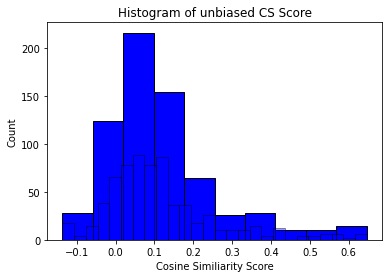

In [0]:
# Import the libraries
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib histogram
plt.hist(result_a_2, color = 'blue', edgecolor = 'black')

# seaborn histogram
sns.distplot(result_a_2, hist=True, kde=False, color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of unbiased CS Score')
plt.xlabel('Cosine Similiarity Score')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

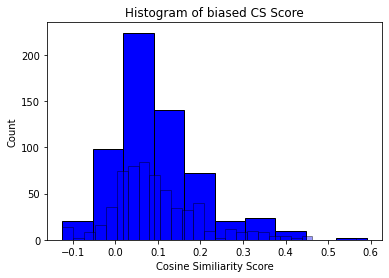

In [0]:
# Import the libraries
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib histogram
plt.hist(result_b_2, color = 'blue', edgecolor = 'black')

# seaborn histogram
sns.distplot(result_b_2, hist=True, kde=False, color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of biased CS Score')
plt.xlabel('Cosine Similiarity Score')
plt.ylabel('Count')

We plotted distribution of the cosine similarity score (average per document) to see if the distrution of the scores were different between the unbias and biased dataset.

The issue here is that the distribution of the cosine similarity score and the number of docs those score occur in is identical for both unbiased and biased articles. We have switched our technique already several times for finding variation. The next thing to check is how to capture better/key words from the document that accurately depict what the article is talking about. 

In [0]:
# This is creating a Model based on the biased/unbiased datasets we have. Very poor results since the previous steps were not successful

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn import metrics
import pickle
class BiasScoreFeature():
    def setup(self): 
        #load the dataset
        unbiased_news = pd.read_csv('/content/drive/My Drive/MLSpring2020/TheMeanSquares-StockPrediction/Alternus-Vera TheMeanSquares/Iteration 1/Datasets/unbiased.csv', low_memory =False)
        biased_news = pd.read_csv('/content/drive/My Drive/MLSpring2020/TheMeanSquares-StockPrediction/Alternus-Vera TheMeanSquares/Iteration 1/Datasets/biased.csv' , low_memory =False)
        combined_news_features = pd.concat([unbiased_news, biased_news], ignore_index=True)
        combined_news_label = combined_news_features['label']
        combined_news_features.drop('label', axis=1)
       
        X_train, X_test, y_train, y_test = train_test_split(combined_news_features, combined_news_label, test_size=0.2)

        countVectorizerHeadlineText = CountVectorizer()
        countVectorizerHeadlineText.fit_transform(combined_news_features['content'])

        self.logR_pipeline = Pipeline([
            ('NBCV',countVectorizerHeadlineText),
            ('nb_clf',MultinomialNB())])

        self.logR_pipeline.fit(X_train['content'], y_train)
        predicted_LogR = self.logR_pipeline.predict(X_test['content'])
        score = metrics.accuracy_score(y_test, predicted_LogR)
        # print("Bias Score Model Trained - accuracy:   %0.6f" % score)

    def predict(self, text):
        predicted = self.logR_pipeline.predict([text])
        predicedProb = self.logR_pipeline.predict_proba([text])[:,1]
        return predicted[0], float(predicedProb)
    
biasscore = BiasScoreFeature()
biasscore.setup()
biasscore.predict("Says the Annies List political group supports third-trimester abortions on demand.")



('bias', 0.16895572026346933)

This was a final model I created using the bias and unbiased dataset. I figured I could use the words as a dictionary of some sort to distinguish between the two types of words. This however doesn't work well and is extremely overfitted. But for the final demo/model, I added this. 

In [0]:
pickle.dump(biasscore, open("/content/drive/My Drive/MLSpring2020/TheMeanSquares-StockPrediction/Alternus-Vera TheMeanSquares/Models/biased_unbiased.sav", 'wb'))

# Data Narrative

## Bias

In our initial research, we looked into using the toxicity dataset (Conversation AI) to determine bias. For the first iteration, we used the words from the toxic dataset and changed the label from toxic to bias, not toxic to unbiased. This was a naive assumption because we can’t assume toxic words don’t occur in unbiased articles. We moved away from this but we will come back to this later.

We talked to our advisor in the second iteration about how we could find variation in the text. The idea here was if there was less variation in the content, the content was more prone to being biased, and vice versa. The first technique we discussed was if we got a single topic of a document, could we check if a word in the topic also had it’s antonym in the list of words for that topic. Using this information and by setting some sort of threshold for the number of antonyms found, we could identify if there is more or less variation in the article and if it is susceptible to bias. We used a random news dataset just to see what results we would get using this technique. We plotted a distribution for the number of docs and number antonyms and to our surprise found that the majority of the docs had zero antonyms. We assumed at this point that using antonyms to find variation would not be vital in determining bias.

We went back to the drawing board with our advisor and decided to change our technique. We concluded from the previous iteration that the technique of checking variation, using antonyms, was the issue. In this next iteration we switched our technique to using cosine similarity. We could use this similarity score on the words in the topics to identify bias. In addition we used a set of fixed biased articles (from the fake news data set) and unbiased articles (from the BBC news data set, subject to our opinion about BBC which is prone to bias). This way we could have baseline ground truth for biased or unbiased articles. We created a distribution of the cosine similarity score and the number of docs that score occurred in biased and unbiased articles. The issue we had was the distribution was identical for both unbiased and biased articles, making it difficult to distinguish between the two.

Due to the limited time, we stopped here and captured our findings. We realized that we need to first make sure that there is a better way to capture the key things the article is talking about in order to apply those techniques to see if the documents have variation. Another thing we could try next time is to use the toxicity dataset as a dictionary. Toxicity does play a role in bias and we could add it as a feature for classification.